**Learning Note 學習筆記 - TensorFlow - Image Classification**<p>
Using TensorFlow to bruild a Neural Network for image classification. There are three groups of X-ray images with labels Covid, Normal and Pneumonia in both train and test data sets.</br>
- The dataset is provided by online learning website, Codecademy, as a challenge project (open ended without step by step instruction). The original data is released by The University of Montreal on Kaggle.<p>

使用TensorFlow打造一個圖片辨識的類神經網路，訓練和測試資料組各有新冠、正常、肺炎三組肺部X光照片。</br>
- 使用線上學習網站Codecademy提供的照片資料，此資料使用在課程的挑戰專案(開放式並無逐步提示)。原始資料來自於蒙特婁大學發布於Kaggle的資料。</br>

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

**Data Loading and Processing 資料載入與處理**<p>
- ImageDataGenerator will load and preprocess image data. Since X-ray image is grarscale image, it means each pixel has value between 0 and 255. Therefore, we would normalize and rescale the images with 1/255.</br>
- There are some other ImageDataGenerator parameters we may use to process image data or generate more data without collecting new data,</br>
    - zoom_range, it will randomly increase or decrease the size. For example, size will increase or decrease up to 20% if it's set as 0.2.</br>
    - rotation_range, it will randomly rotate the image. For example, images will be rotated between -20 and 20 degree when it's set as 20.</br>
    - width_shift_range, it will randomly shift images along its width by +/- 10% when it's set as 0.1.</br>
    - height_shift_range, similar to previous one, it will randomly shift images along its height by +/- 10% when it's set as 0.1.</br>
    - vertical_flip, it will flip images up side down when it's set as True.</br>
- Load data with flow_from_directory, parameters:</br>
    - Directory of data location.</br>
    - class_mode, depends on the labels classes,</br>
        - "categorical", one-hot-encoding type of labels, there will be only one "1" (and others are "0") on the output list. For example [0, 1, 0, 0].</br>
        - "binary", there will be only one number on the output.</br>
        - "sparse", similar will "binary", but is designed for multilabel classification.</br>
    - color_mode, since X-ray is grayscale image so we set it "grayscale", for color images we could use "rgb".</br>
    - target_size, the size of images, all the data will be resized into this. We set it 256x256 pixel.</br>
    - batch_size, how many data in a batch.<p>
</br>
- 使用ImageDataGenerator來載入與處理資料。由於X光照片是灰階圖片(白到黑)，每個像素的值會介於0到255之間，因此以1/255來標準化圖片。</br>
- 另外還有一些ImageDataGenerator的參數，可以用來處理圖片，或對圖片做一些調整，以在不需要蒐集新資料的狀況下生成更多訓練資料。</br>
    - zoom_range, 可以在所設定的數值內，隨機放大或縮小圖片尺寸。比方說當設定為0.2，圖片就會被隨機放大或縮小至多20%。</br>
    - rotation_range, 可以在所設定的數值內，順時針或逆時間隨機旋轉圖片。比方說當設定為20，圖片就會被隨機旋轉-20至20度。</br>
    - width_shift_range, 可以在所設定的數值內，隨機水平偏移圖片。比方說當設定為0.1，圖片就會被向左或向右隨機偏移至多10%。</br>
    - height_shift_range, 與前一個類似，這個參數則是垂直偏移圖片。比方說當設定為0.1，圖片就會被向上或向下隨機偏移至多10%。</br>
    - vertical_flip, 當設定為True時，圖片會被上下鏡向顛倒。</br>
- 使用ImageDataGenerator的flow_from_directory載入資料，參數如下。</br>
    - 資料被放置在的路徑位置。</br>
    - class_mode, 取決於label的形式:</br>
        - "categorical", 當label為one-hot-encoding型式，輸出串列裡只會有一個"1"，比方說[0, 1, 0, 0]。</br>
        - "binary", 輸出只會有一個數字。</br>
        - "sparse", 與"binary"類似，但被設計用在label有超過2種以上的分類。</br>
    - color_mode, 由於X光照片是灰階圖片，因此使用"grayscale"。彩色圖片則使用"rgb"。</br>
    - target_size, 所有資料圖片都會被轉換成這個尺寸。我們的圖片設定為256x256像素。</br>
    - batch_size, 一個batch有多少資料。<p>

In [5]:
batches = 32

train_generator = ImageDataGenerator(rescale=1./255)
train_data = train_generator.flow_from_directory('Covid19-dataset/train', class_mode='sparse', color_mode='grayscale', target_size=(256, 256), batch_size=batches)
test_generator = ImageDataGenerator(rescale=1./255)
test_data = test_generator.flow_from_directory('Covid19-dataset/test', class_mode='sparse', color_mode='grayscale', target_size=(256, 256), batch_size=batches)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


**Create Convolutional Neural Network Model 打造卷積神經網路模組**<p>
- Sequential model is a popular model to build neural network. Layers by layers.</br>
- Since the images are 256x256 pixels and grayscale so the shape is set as (256, 256, 1). The last digit refers to image channel, it will be 3 if it is color image (r, g ,b).</br>
- Convolutional Neural Networks (CNN) works better for image data.</br>
    - There are usually some patterns formed by nearby features in image data. These patterns would be captured by CNN.</br>
    - CNN will reduce the size of input images.</br>
    - CNN uses filters to generate new images, which encourages the model to look for local patterns.</br>
    - CNN will produce similar output even if objects in the image has been traslated.</br>
- Prameters of Convolutional Layers:</br>
    - Numbers of filters, convolutional layers use filters to produce several outputs (one for each filter) then stack them together to generate new image.</br>
    - Size of filters, the width and height of the filters in pixels. 3x3 and 5x5 are commonly used.</br>
    - strides, how much the filter move in pixel each time, default is 1.</br>
    - padding, what happens when the filter reach the edge of image.</br>
        - "valid", default option, filter just stop moving.</br>
        - "same", zeros will be added arround the images so that the output size will be the same as input image.</br>
    - activation function, Relu is an effective and popular function.</br>
- Pooling, it moves similar with filter but instead Max pooling replaces the patch with its maximum value. Max pooling helps reduce the size of hidden layers, numbers of parameters to be learned and overfitting, it also provides some amount of translational invariance. Parameters are pool_size, strides and padding.</br>
- Stacking layers, neural network layers could be stacked to learn richer combination of features.</br>
- Flatten, we have to convert data to one dimension since our Dense layer will be single vector output.</br>
- Output layer (Dense), we use "softmax" because of single vector ouput, we may use "sigmoid" if output it is binary classification.</br>
- compile, since we have sparse class mode, loss function and metrics are set as "sparse_categorical_crossentropy" and "sparse_categorical_accuracy".<p>
</br>
- Sequential是常見的類神經網路模組。</br>
- 因為資料是256x256象素的灰階圖片，因此輸入層設定為(256, 256, 1)，最後一個數字是圖片通道，灰階圖片僅會有1個數值(0到255)，彩色圖片的話就會是3(紅/綠/藍)。</br>
- 卷積神經網路有強大的圖片影像辨識能力。</br>
    - 圖片資料通常會有一些由相鄰區域組成的規律，如使用前饋類神經網路(Feedforward Neural Networks)會破壞掉這些規律，卷積神經網路成夠抓到這些規律。</br>
    - 卷積神經網路可以縮減輸入圖片的尺寸。</br>
    - 卷積神經網路使用濾鏡(filters)來產生新圖片，此方式能讓模組尋找區域內的規律。</br>
    - 當圖片有被轉換修改過，比方說圖片裡的物體被顛倒或平移，整卷積神經網路仍能夠產生類似的輸出。</br>
- 卷積層參數: </br>
    - 濾鏡數量，卷積層數用濾鏡來產生多個輸出(每個濾鏡各一個)，然後將這些輸出疊在一起生成新的圖片。</br>
    - strides, 濾鏡每次移動的步伐，預設值為1。</br>
    - padding, 當濾鏡移動到圖片邊緣時是否進行填充。</br>
        - "valid", 預設值，當濾鏡到達邊緣即停止。</br>
        - "same", 會在圖片周圍補上一層0值，使輸出會跟輸入圖片一樣尺寸。</br>
    - activation function, 激勵函數(Activation function)，Relu是常見且有效率的激勵函數。</br>
- Pooling, 池化層，移動的方式類似卷積層，最大池化(Max pooling)會挑出矩陣內最大的數值。可以減少隱藏層的大小、學習參數的數量、以及overfitting，同時也能減少圖片被轉換修改過的影響。參數有pool_size, strides and padding。</br>
- 神經網路能夠被層層堆疊，以學習更多樣的features組合。</br>
- Flatten, 攤平，因為輸出是單一向量維度，因此需要將資料轉換為單維度。</br>
- 輸出層，使用"softmax"在單一向量維度，如為二元分類可使用"sigmoid"。</br>
- 編譯，因為使用"sparse" class mode，所以損失函數與評估指標設定為"sparse_categorical_crossentropy"和"sparse_categorical_accuracy"。<p>

In [7]:
model = Sequential()
model.add(keras.Input(shape=(256, 256, 1)))
model.add(layers.Conv2D(5, 5, strides=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))
model.add(layers.Conv2D(3, 3, strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 84, 84, 5)      │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 3)      │           138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           784 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,052 (4.11 KB)

 Trainable params: 1,052 (4.11 KB)

 Non-trainable params: 0 (0.00 B)

None


**Fit the model 訓練模組**<p>
- Early Stopping, preventing overfitting if the number of epochs is large.</br>
    - We monitor the model by its "sparse_categorical_crossentropy".</br>
    - patience parameter tells the model how many more epochs we monitor if the model reachs plateau.</br>
- Fit model parameters:</br>
    - training dataset.</br>
    - steps_per_epoch, the number of images in dataset divided by batch size.</br>
    - validation dataset.</br>
    - validation_steps, simillar to steps_per_epoch.</br>
    - callbacks, we apply the Early Stopping function.<p>
</br>
- 如果有很大的epochs時，提前停止(Early Stopping)可用來防止overfitting。</br>
    - 使用"sparse_categorical_crossentropy"來監測模組。</br>
    - pateience參數告訴模組，當模組學習曲線達到平坦位置後，要再多監測多少epochs再停止。</br>
- 模組參數</br>
    - 訓練資料。</br>
    - steps_per_epoch, 訓練資料的圖片數量除以batch。</br>
    - 驗證資料。</br>
    - validation_steps, 類似steps_per_epoch。</br>
    - callbacks, 使用方才設定的提前停止涵式。<p>

In [9]:
es = EarlyStopping(monitor='sparse_categorical_accuracy', patience=15)
history = model.fit(train_data, steps_per_epoch=len(train_data)//batches, epochs=100, validation_data=test_data, validation_steps=len(test_data)//batches, callbacks=[es])


Epoch 1/100


C:\Users\Fenrir\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 2.5362 - sparse_categorical_accuracy: 0.1768 - val_loss: 1.2899 - val_sparse_categorical_accuracy: 0.3939
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 1.1314 - sparse_categorical_accuracy: 0.4638 - val_loss: 0.9949 - val_sparse_categorical_accuracy: 0.5152
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.9763 - sparse_categorical_accuracy: 0.5935 - val_loss: 0.9400 - val_sparse_categorical_accuracy: 0.6061
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.8790 - sparse_categorical_accuracy: 0.5729 - val_loss: 0.8494 - val_sparse_categorical_accuracy: 0.5606
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.7052 - sparse_categorical_accuracy: 0.7276 - val_loss: 0.6744 - val_sparse_categorical_accuracy: 0.7879
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.5729 - sparse_categorical_accuracy: 0.8051 - val_loss: 0.6818 - val_sparse_categorical_accuracy: 0.7121
Epoch 7/100
8/8 ━━━━━━━━━━━

**Plotting 繪圖**<p>
Plotting the Accuracy and Loss of the model.</br>
繪製模組訓練的準確率和損失曲線。</br>

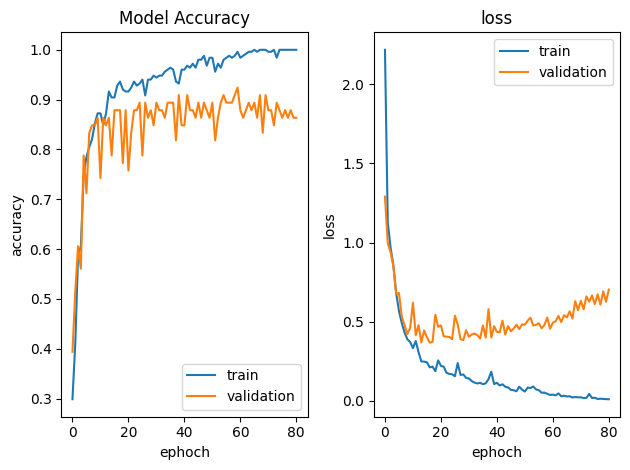

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(history.history['sparse_categorical_accuracy'])
ax1.plot(history.history['val_sparse_categorical_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('ephoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax2 = fig.add_subplot(1, 2 ,2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('loss')
ax2.set_xlabel('ephoch')
ax2.set_ylabel('loss')
ax2.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()
plt.show()

**Evaluation and Adjustment 評估與調教**<p>
- Accuracy </br>
    - Underfit, training and validation accuracy are low.</br>
    - Overfit, training acuracy is high but validation acuracy is low or much lower than training. Or validaiton goes up and down.</br>
    - Good fit, training acuracy is high and validation acuracy slightly lower.<p>
- Obviously the model is **overfitting**.<p>
- Adjustments</br>
    - Make the model simpler. Such as decrease number of filters and increase pooling size.</br>
    - Add a dropout layer.</br>
    - Decrease learning rate.</br>
- After several trys of combination, it looks better.<p>
</br>
- 準確率 </br>
    - Underfit, 訓練準確率和驗證準確率都低。</br>
    - Overfit, 訓練準確率高，但驗證準確率低或大幅低於訓練準確率。或者驗證準確率大幅忽高忽低。</br>
    - Good fit, 訓練準確率高，且驗證準確率稍微低一點。<p>
- 很明顯模型**overfitting**。<p>
- 調整參數</br>
    - 簡化模型，比方說減少濾鏡數量或加大池化層尺寸。</br>
    - 加入丟棄層(Dropout)。</br>
    - 降低學習率(Learning Rate)。</br>
- 經過無數次的嘗試後，模型準確率看起來好多了。<p>


In [13]:
model2 = Sequential()
model2.add(keras.Input(shape=(256, 256, 1)))
model2.add(layers.Conv2D(4, 5, strides=2, activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(5, 5), strides=(3, 3)))
model2.add(layers.Conv2D(3, 3, strides=2, activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(16, activation='softmax'))

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.004), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

history2 = model2.fit(train_data, steps_per_epoch=len(train_data)//batches, epochs=100, validation_data=test_data, validation_steps=len(test_data)//batches, callbacks=[es])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 2.3152 - sparse_categorical_accuracy: 0.4263 - val_loss: 1.5221 - val_sparse_categorical_accuracy: 0.3939
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 1.3361 - sparse_categorical_accuracy: 0.4473 - val_loss: 1.1029 - val_sparse_categorical_accuracy: 0.3030
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 1.1877 - sparse_categorical_accuracy: 0.3432 - val_loss: 1.1023 - val_sparse_categorical_accuracy: 0.3182
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 1.1437 - sparse_categorical_accuracy: 0.4096 - val_loss: 1.0157 - val_sparse_categorical_accuracy: 0.4697
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 1.0474 - sparse_categorical_accuracy: 0.5235 - val_loss: 0.9511 - val_sparse_categorical_accuracy: 0.6515
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.9509 - sparse_categorical_accuracy: 0.5352 - val_loss: 0.8254 - val_sparse_categorical_accuracy: 0.8333
Epoch 7/100
8/8

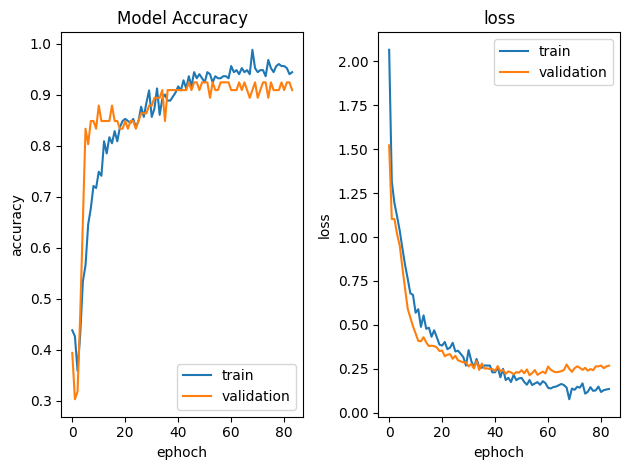

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(history2.history['sparse_categorical_accuracy'])
ax1.plot(history2.history['val_sparse_categorical_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('ephoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax2 = fig.add_subplot(1, 2 ,2)
ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_title('loss')
ax2.set_xlabel('ephoch')
ax2.set_ylabel('loss')
ax2.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()
plt.show()